## Benchmarking genetic perturbation prediction in human PSC's

This project aims to assess the ability of modern datasets and software tools to predict the effect of genetic perturbations on the transcriptome. Check out [the proposal](https://docs.google.com/document/d/1vvZi5c0nU3VTvKiWpEka8AtDORxJ3Ymv0ZzoFQwoDoI/edit) for more information.

There are several opportunities for interesting work in this area. This demo focuses on *causal structure inference* and *causal effect estimation* by pairing CellOracle with various different base networks. 

In [74]:
# Setup
import warnings
with warnings.catch_warnings():
    import regex as re
    import os
    import sys
    import matplotlib.colors as colors
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scanpy as sc
    import seaborn as sns
    import celloracle as co
    from scipy.stats import spearmanr as spearmanr
    # visualization settings
    %config InlineBackend.figure_format = 'retina'
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [6, 4.5]
    plt.rcParams["savefig.dpi"] = 300

### Basic infrastructure

The software for this project will provide quick access to a variety of modeling choices, especially different base networks, different network structure pruning methods, possibly different learning algorithms, and definitely different handling of velocity and timestamps. We will try to separate this into one-off components specific to each dataset or comparison and reusable components. Here is a rough draft of one reusable component, for training models with various base networks.

In [75]:
def trainCausalModelAndPredict(expression, 
                               baseNetwork, 
                               memoizationName,
                               perturbations,
                               pruningParameters = {"p":0.001, "threshold_number":2000}):
    """Train a causal model and predict outcomes of unseen perturbations."""
    oracle = co.Oracle()
    oracle.import_anndata_as_raw_count(adata=ko_lab_esc_data,
                                   cluster_column_name="leiden",
                                   embedding_name="X_pca")
    oracle.import_TF_data(TF_info_matrix=baseNetwork)
    oracle.perform_PCA()
    n_comps = 50
    k = 1
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                          b_maxl=k*4, n_jobs=4)
    # Ridge regression pruning
    # This step may take some time.(~30 minutes)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        links = oracle.get_links(cluster_name_for_GRN_unit="leiden", 
                                 alpha=10, 
                                 model_method = "bayesian_ridge",
                                 verbose_level=10,    
                                 test_mode=False, 
                                 n_jobs=14)
        links.filter_links(p=pruningParameters["p"], 
                           weight="coef_abs", 
                           threshold_number=pruningParameters["threshold_number"])
    
    links.links_dict = links.filtered_links.copy()
    oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
    oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
    oracle.to_hdf5(file_path=memoizationName)

    output = {}
    for goi, level in perturbations:
        print("Predicting " + goi)
        try:
            oracle.simulate_shift(perturb_condition={goi: level}, n_propagation=3, ignore_warning = True)
            output[goi] = oracle.adata["Control",:].layers['simulated_count'].squeeze()
        except ValueError as e:
            output[goi] = np.nan
            print("Prediction failed for " + goi + " with error " + str(e))
    return output

### Base network options

The project will also develop a reusable collection of datasets on *perturbation experiments* and *network structures* stored in a standardized format. This is not very far along at time of writing, but here are some of the networks structures we will use for this example. 

- CellOracle default (motif analysis of promoters)
- Motif analysis of ENCODE DNase hypersensitivity data
- Motif analysis of FANTOM5 CAGE-seq data
- The union of the three
- A completely dense network with all connections allowed

We set these up below. Eventually we'll want to replace this with a call to a reusable function where we just tell it "Give me networks A, B and C" and it spits out the right format.

In [76]:
humanTFs = pd.read_csv("../../accessory_data/humanTFs.csv")
targetGenes = co.data.load_human_promoter_base_GRN()["gene_short_name"]
def networkEdgesToMatrix(networkEdges, regulatorColumn=0, targetColumn=1):
    X = pd.crosstab(networkEdges[targetColumn], networkEdges[regulatorColumn])
    X = X.rename_axis('gene_short_name').reset_index()
    X = X.rename_axis('peak_id').reset_index()
    return X

networks = {
    # this fantom5 one needs work to best apply to ESC's. 
    # I want to get either the primordial germ cell network, or the union of all FANTOM5 networks. 
 #   'fantom5': "../../raw_networks/fantom5_networks/",
    'encodeDNase': networkEdgesToMatrix(
        pd.read_csv("../../raw_networks/encode_dnase/networks.v09162013/net/lebowski/vol1/work/sjn/papers/regnetworks.resubmission.official/create.networks.per.celltype/results.regulators.combine.all/buffer.5000/hESCT0-DS11909/genes.regulate.genes", 
                               sep = "\t", header=None)
    ),
    'cellOracle': co.data.load_human_promoter_base_GRN(),
    'dense': 
    pd.DataFrame(
        np.ones(
            shape=(
                len(targetGenes), 
                len(humanTFs['HGNC symbol'])
            )
        ),
        columns = humanTFs['HGNC symbol'], 
        index = targetGenes
    ).rename_axis('gene_short_name').reset_index().rename_axis('peak_id').reset_index()
}
sharedRegulators = set.intersection(*[set(networks[key]['gene_short_name']) for key in networks])

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [77]:
[print(bn+'\n\n\n',networks[bn].iloc[0:2, 0:5]) for bn in networks]

encodeDNase


 0  peak_id gene_short_name  AHR  AIRE  ALX1
0        0             AHR    0     0     0
1        1            AIRE    0     0     0
cellOracle


                      peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100027907_100029007           LOXL4            0.0         0.0   
1  chr10_100154964_100156064         MIR1287            0.0         0.0   

   AC012531.1  
0         0.0  
1         0.0  
dense


 HGNC symbol  peak_id gene_short_name  TFAP2A  TFAP2B  TFAP2C
0                  0           LOXL4     1.0     1.0     1.0
1                  1         MIR1287     1.0     1.0     1.0


[None, None, None]

### PSC overexpression example

This demo uses a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression.

In [78]:
ko_lab_esc_data = pd.read_csv("../../raw_perturbations/ko_esc/CREST_06162021.txt", 
                              delimiter="\t", index_col=0, header=0, comment = '!')
gene_metadata   = ko_lab_esc_data.iloc[:,-4:]
ko_lab_esc_data = ko_lab_esc_data.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = ko_lab_esc_data.index,
                               data = [re.sub("\.1", "", g) for g in ko_lab_esc_data.index])

In [79]:
def missingDataPerGene(ko_lab_esc_data):
    gene_metadata["fraction_missing"] = pd.DataFrame.mean(ko_lab_esc_data==-9999)
    missingness_rates = gene_metadata["fraction_missing"].value_counts()
    missingness_rates = pd.DataFrame(index = range(len(missingness_rates.index)), 
                                 data = {"Fraction of samples missing":np.array(missingness_rates.index), 
                                         "Number of genes": np.array(missingness_rates)})
    print("Missing data per gene:")
    print(missingness_rates)
    
missingDataPerGene(ko_lab_esc_data)
for sample in ko_lab_esc_data.index:
    missing = ko_lab_esc_data.loc[sample,:]==-9999
    ko_lab_esc_data.loc[sample,missing] = ko_lab_esc_data.loc["Control",missing]
missingDataPerGene(ko_lab_esc_data)

ko_lab_esc_data = sc.AnnData(ko_lab_esc_data, 
                             var = gene_metadata,
                             obs = sample_metadata)
ko_lab_esc_data

Missing data per gene:
   Fraction of samples missing  Number of genes
0                     0.000000            20032
1                     0.151186             4804
2                     0.000988              214
3                     0.152174               33
4                     0.001976                7
Missing data per gene:
   Fraction of samples missing  Number of genes
0                          0.0            25090


AnnData object with n_obs × n_vars = 1012 × 25090
    obs: 'perturbation'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing'

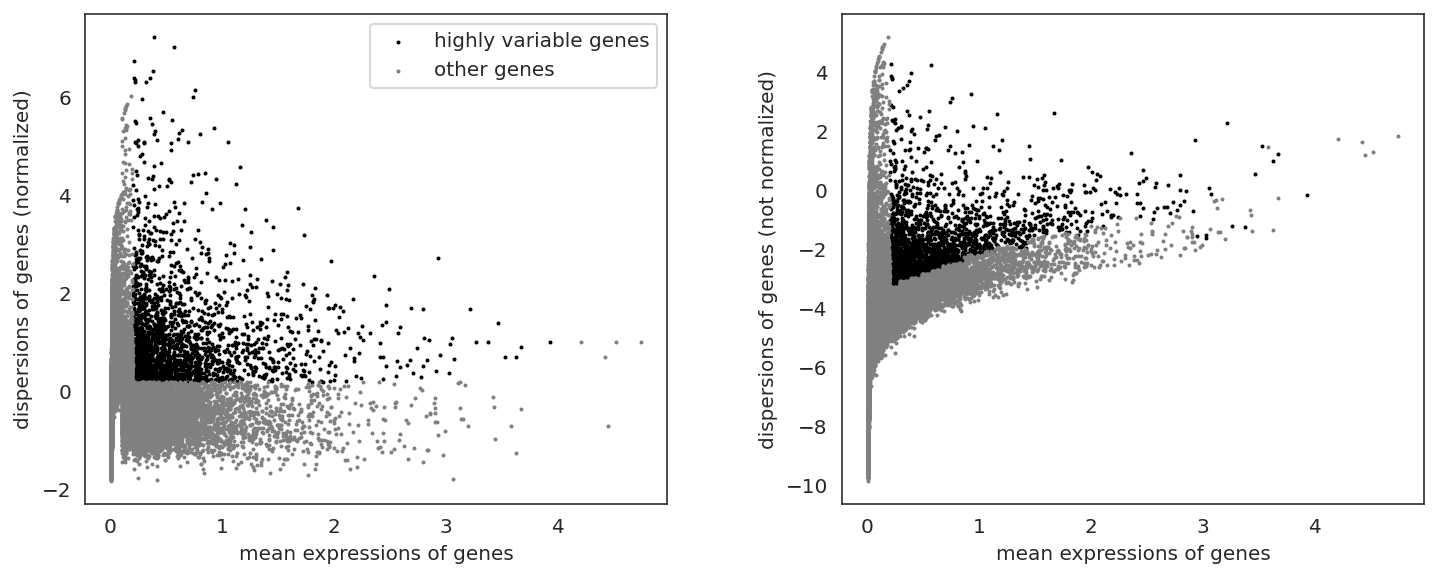

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'perturbation' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Symbol' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning

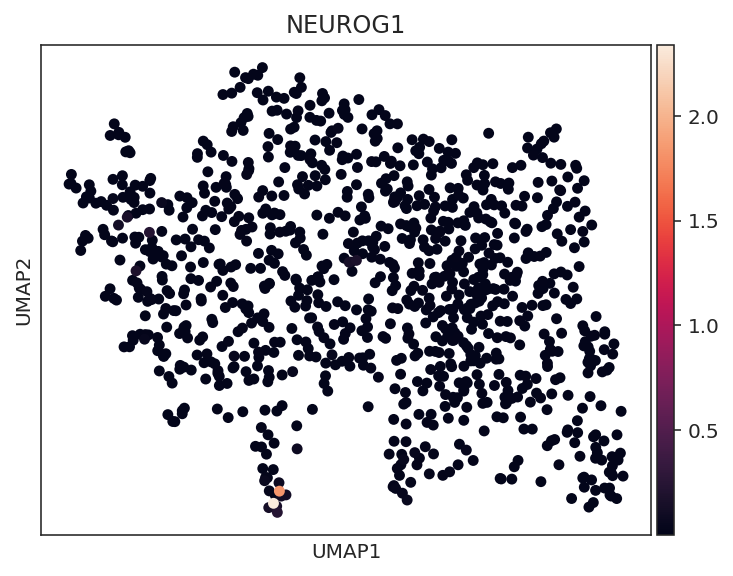

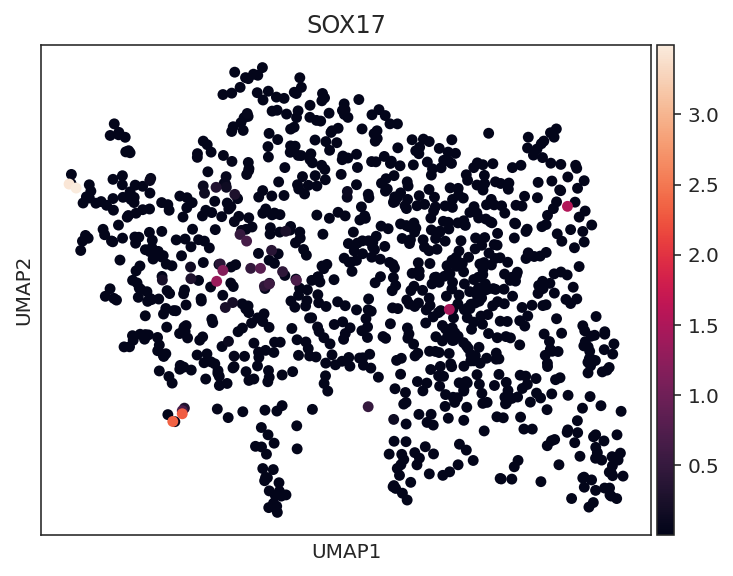

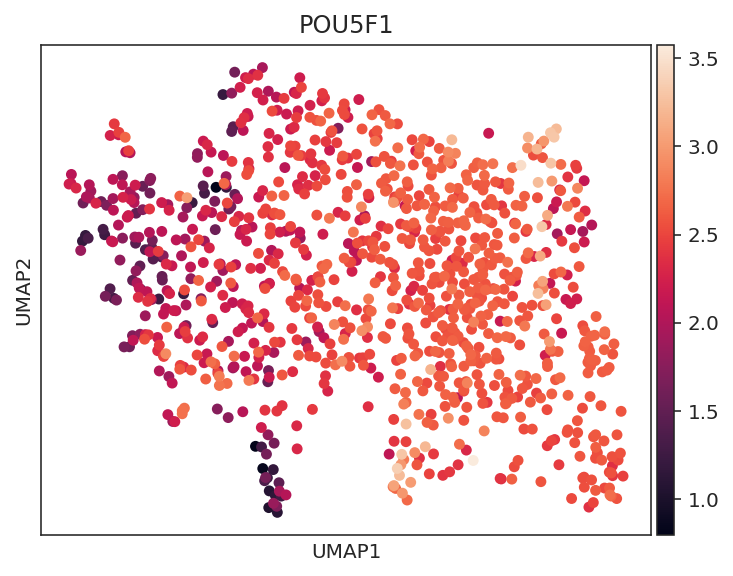

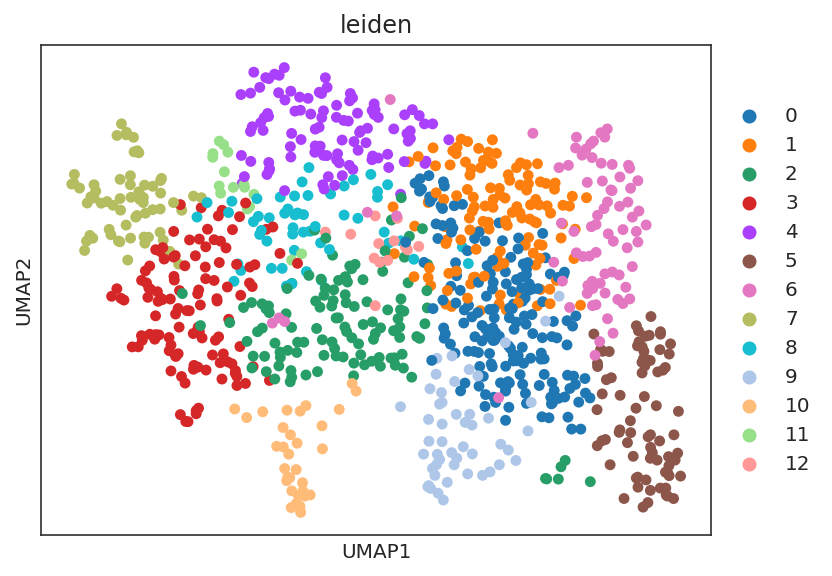

In [80]:
sc.pp.normalize_total(ko_lab_esc_data, target_sum=1e4)
sc.pp.log1p(ko_lab_esc_data)
# These settings are good for fast debugging, but will select too few genes for a full run.
sc.pp.highly_variable_genes(ko_lab_esc_data, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(ko_lab_esc_data)
with warnings.catch_warnings():
    sc.tl.pca(ko_lab_esc_data, n_comps=100)
sc.pp.neighbors(ko_lab_esc_data)
sc.tl.umap(ko_lab_esc_data)
sc.tl.leiden(ko_lab_esc_data)
sc.pl.umap(ko_lab_esc_data, color = "NEUROG1")
sc.pl.umap(ko_lab_esc_data, color = "SOX17")
sc.pl.umap(ko_lab_esc_data, color = "POU5F1")
sc.pl.umap(ko_lab_esc_data, color = "leiden")

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. 

In [81]:
perturbed_genes = set(ko_lab_esc_data.obs['perturbation']).intersection(ko_lab_esc_data.var.index)
genes_keep = ko_lab_esc_data.var.index[ko_lab_esc_data.var['highly_variable']]
genes_keep = list(set(genes_keep).union(perturbed_genes))
ko_lab_esc_data = ko_lab_esc_data[:,genes_keep]

### Training and test split

One frequent complication: perturbed genes may be absent from most base GRN's due to lack of motif information or ChIP data. We test on perturbations of TF's present in all base GRN's and train on the rest. 

In [82]:
testSetPerturbations     = set(ko_lab_esc_data.obs['perturbation']).intersection(sharedRegulators)
trainingSetPerturbations = set(ko_lab_esc_data.obs['perturbation']).difference(sharedRegulators)
ko_lab_esc_data_heldout  = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(testSetPerturbations),    :]
ko_lab_esc_data_train    = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(trainingSetPerturbations),:]
perturbationsToPredict = [(gene, ko_lab_esc_data_heldout[sample, gene].X[0,0]) for sample,gene in enumerate(ko_lab_esc_data_heldout.obs['perturbation'])] 
print(perturbationsToPredict[0:5])
ko_lab_esc_data_train

[('ALX3', 2.829177), ('ALX3', 3.583377), ('ALX4', 1.1726332), ('ALX4', 0.7964212), ('AR', 1.1614258)]


View of AnnData object with n_obs × n_vars = 553 × 2603
    obs: 'perturbation', 'leiden'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### OK, let's do this. 

In [95]:
experiments = pd.DataFrame({"network":[n for n in networks.keys() for i in range(2)], 
                            "p":[0.001, 1]*3,
                            "threshold_number":[2000, 100_000]*3,
                            "pruning":["harsh", "lax"]*3})
experiments["index"] = experiments.index

In [84]:
predictions = {
    i: trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName=str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 10...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 11...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 12...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 5...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 8...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 159 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 142 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 151 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 143 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 152 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 138 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 132 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 159 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 133 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 109 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 127 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 137 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 102 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Predicting DLX2
Predicting DLX5
Predicting DLX5
Predicting DMRT1
Predicting DMRT1
Predicting E2F1
Predicting E2F1
Predicting E2F4
Predicting E2F4
Predicting E2F6
Predicting E2F6
Predicting E2F7
Predicting E2F7
Predicting EBF1
Predicting EBF1
Predicting EGR1
Predicting EGR1
Predicting EGR2
Predicting EGR2
Pre

Predicting NR2F1
Predicting NR2F2
Predicting NR2F2
Predicting NR3C1
Predicting NR3C1
Predicting NR5A1
Predicting NR5A1
Predicting NRF1
Predicting NRF1
Predicting OTP
Predicting OTP
Predicting OTX1
Predicting OTX1
Predicting OTX2
Predicting OTX2
Predicting PATZ1
Predicting PATZ1
Predicting PAX2
Predicting PAX2
Predicting PAX5
Predicting PAX5
Predicting PAX6
Predicting PAX6
Predicting PAX8
Predicting PAX8
Predicting PBX1
Predicting PBX1
Predicting PDX1
Predicting PDX1
Predicting PITX2
Predicting PITX2
Predicting PITX3
Predicting PITX3
Predicting POU2AF1
Prediction failed for POU2AF1 with error Gene POU2AF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting POU2AF1
Prediction failed for POU2AF1 with error Gene POU2AF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting POU2F2
Predicting POU2F2
Predicting POU3F2
Predicting POU3F2
Predicting PO

  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 10...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 11...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 12...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 4...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 5...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/259 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 8...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/259 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 253 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Predicting DLX2
Predicting DLX5
Predicting DLX5
Predicting DMRT1
Predicting DMRT1
Predicting E2F1
Predicting E2F1
Predicting E2F4
Predicting E2F4
Predicting E2F6
Predicting E2F6
Predicting E2F7
Predicting E2F7
Predicting EBF1
Predicting EBF1
Predicting EGR1
Predicting EGR1
Predicting EGR2
Predicting EGR2
Pre

Predicting PRDM1
Predicting RARA
Predicting RARA
Predicting RARG
Predicting RARG
Predicting REST
Predicting REST
Predicting RFX2
Predicting RFX2
Predicting RFX5
Predicting RFX5
Predicting RFXAP
Predicting RFXAP
Predicting RREB1
Predicting RREB1
Predicting RUNX1
Predicting RUNX1
Predicting RUNX3
Predicting RUNX3
Predicting RXRA
Predicting RXRA
Predicting SMAD1
Predicting SMAD1
Predicting SMAD2
Predicting SMAD2
Predicting SMAD3
Predicting SMAD3
Predicting SMAD4
Predicting SMAD4
Predicting SMAD5
Predicting SMAD7
Predicting SMAD7
Predicting SOX10
Predicting SOX10
Predicting SOX11
Predicting SOX11
Predicting SOX14
Predicting SOX14
Predicting SOX15
Predicting SOX15
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Predicting SOX5
Predicting SOX6
Predicting SOX6
Predicting SOX9
Predicting SOX9
Predicting SPI1
Predicting SPI1
Predicting SPIB
Predicting SPIB
Predicting SPZ1
Prediction failed for SPZ1 with error Gene SPZ1 is not included in the base GRN; It is not

  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 10...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 11...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 12...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 706 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 327 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 728 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 881 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 573 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 417 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 369 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 429 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 405 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 431 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 544 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 526 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 423 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Prediction failed for DLX2 with error Gene DLX2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting DLX2
Prediction failed for DLX2 with error Gene DLX2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting DLX5
Predicting DLX5

Predicting RXRA
Predicting SMAD1
Predicting SMAD1
Predicting SMAD2
Predicting SMAD2
Predicting SMAD3
Predicting SMAD3
Predicting SMAD4
Predicting SMAD4
Predicting SMAD5
Prediction failed for SMAD5 with error Gene SMAD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SMAD7
Prediction failed for SMAD7 with error Gene SMAD7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SMAD7
Prediction failed for SMAD7 with error Gene SMAD7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX10
Predicting SOX10
Predicting SOX11
Predicting SOX11
Predicting SOX14
Predicting SOX14
Predicting SOX15
Predicting SOX15
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It 

  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 10...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 11...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 12...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 5...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 9...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2223 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2181 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2291 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2286 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2255 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2248 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2289 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2238 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2216 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2185 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2285 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2272 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2245 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Predicting DLX2
Predicting DLX5
Predicting DLX5
Predicting DMRT1
Predicting DMRT1
Predicting E2F1
Predicting E2F1
Predicting E2F4
Predicting E2F4
Predicting E2F6
Predicting E2F6
Predicting E2F7
Predicting E2F7
Predicting EBF1
Predicting EBF1
Predicting EGR1
Predicting EGR1
Predicting EGR2
Predicting EGR2
Pr

Predicting SOX10
Predicting SOX11
Predicting SOX11
Predicting SOX14
Predicting SOX14
Predicting SOX15
Predicting SOX15
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX5
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX6
Predicting SOX6
Predicting SOX9
Predicting SOX9
Predicting SPI1
Predicting SPI1
Predicting SPIB
Predicting SPIB
Predicting SPZ1
Predicting SPZ1
Predicting SREBF2
Predicting SREBF2
Predicting STAT3
Predicting STAT3
Predicting STAT4
Predicting STAT4
Predicting STAT5A
Predicting STAT5A
Predicting TAL1
Predicting TAL1
Predicting TBX5
Predicting TBX5
Predicting TCF12
Predicting TCF12
Predicting TCF4
Predicting TCF4
Predicting TFAP2A
Predictin

  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 11...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 12...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 7...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 105 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 139 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 665 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 765 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 826 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 312 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 488 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 330 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 205 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 260 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 625 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 435 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 296 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Predicting DLX2
Predicting DLX5
Predicting DLX5
Predicting DMRT1
Predicting DMRT1
Predicting E2F1
Predicting E2F1
Predicting E2F4
Predicting E2F4
Predicting E2F6
Predicting E2F6
Predicting E2F7
Predicting E2F7
Predicting EBF1
Predicting EBF1
Predicting EGR1
Predicting EGR1
Predicting EGR2
Predicting EGR2
Pre

  0%|          | 0/13 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 10...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 11...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 12...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 2...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 3...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 4...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 5...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


inferring GRN for 6...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 7...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 8...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

inferring GRN for 9...


  0%|          | 0/2407 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2168 genes
calculating GRN in 1


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2163 genes
calculating GRN in 10


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2258 genes
calculating GRN in 11


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2236 genes
calculating GRN in 12


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2254 genes
calculating GRN in 2


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2230 genes
calculating GRN in 3


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2243 genes
calculating GRN in 4


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2208 genes
calculating GRN in 5


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2187 genes
calculating GRN in 6


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2058 genes
calculating GRN in 7


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2220 genes
calculating GRN in 8


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2228 genes
calculating GRN in 9


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2157 genes
Predicting ALX3
Predicting ALX3
Predicting ALX4
Predicting ALX4
Predicting AR
Predicting AR
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ATF1
Predicting ATF1
Predicting ATF2
Predicting ATF2
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BACH1
Predicting BACH1
Predicting BARHL2
Predicting BARHL2
Predicting BCL6
Predicting BCL6
Predicting BHLHE40
Predicting BHLHE40
Predicting CDX2
Predicting CDX2
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CREB1
Predicting CREB1
Predicting CUX1
Predicting CUX1
Predicting DLX2
Predicting DLX2
Predicting DLX5
Predicting DLX5
Predicting DMRT1
Predicting DMRT1
Predicting E2F1
Predicting E2F1
Predicting E2F4
Predicting E2F4
Predicting E2F6
Predicting E2F6
Predicting E2F7
Predicting E2F7
Predicting EBF1
Predicting EBF1
Predicting EGR1
Predicting EGR1
Predicting EGR2
Predicting EGR2
Pr

In [85]:
predictions[0]

{'ALX3': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ALX4': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'AR': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ARNT2': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ASCL1': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ATF1': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ATF2': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ATF3': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),
 'ATOH1': ArrayView([0.2898187 , 0.17002496, 0.20047694, ..., 0.2110022 ,
            0.47097018, 0.18644106]),


### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [96]:
def evaluateCausalModel(expression, predictedExpression, baseline, doPlots=False):
    plots = {}
    metrics = pd.DataFrame(index = predictedExpression.keys(), columns = ["spearman", "spearmanp"])
    for key in predictedExpression:
        observed = expression[expression.obs["perturbation"]==key,:].X.mean(axis=0) - baseline
        predicted = predictedExpression[key] - baseline
        if not any(np.isnan(predicted)):
            metrics.loc[key,["spearman","spearmanp"]] = spearmanr(observed, predicted)
        else:    
            metrics.loc[key,["spearman","spearmanp"]] = 0,1
        if doPlots:
            plots[key] = sns.scatterplot(x=observed, y=predicted)
            plots[key].set(title=key + " (Spearman rho="+ str(round(metrics.loc[key,"spearman"])) +")")
            plots[key].set_xlabel("Observed log fc", fontsize = 20)
            plots[key].set_ylabel("Predicted log fc", fontsize = 20)
            plots[key].plot()
            plt.figure()
    metrics["perturbation"] = metrics.index
    return metrics, plots            

In [122]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluationResults = {}
for i in predictions:
    evaluationResults[i] = \
        evaluateCausalModel(ko_lab_esc_data_heldout, 
                            predictions[i],   
                            baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0),     
                            doPlots=False)[0]
    evaluationResults[i]["index"] = i
evaluationResults = pd.concat(evaluationResults)
evaluationResults = evaluationResults.merge(experiments, how = "left")
evaluationResults = pd.DataFrame(evaluationResults.to_dict())
evaluationResults.head()

,spearman,spearmanp,perturbation,index,network,p,threshold_number,pruning
0,0.239083,3.709844e-35,ALX3,0,encodeDNase,0.001,2000,harsh
1,0.189472,1.834027e-22,ALX4,0,encodeDNase,0.001,2000,harsh
2,0.202574,1.650616e-25,AR,0,encodeDNase,0.001,2000,harsh
3,0.189612,1.706266e-22,ARNT2,0,encodeDNase,0.001,2000,harsh
4,0.246724,2.126742e-37,ASCL1,0,encodeDNase,0.001,2000,harsh


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Predicted versus observed log FC'),
 Text(0.5, 0, 'Spearman correlation\n(average over all methods)')]

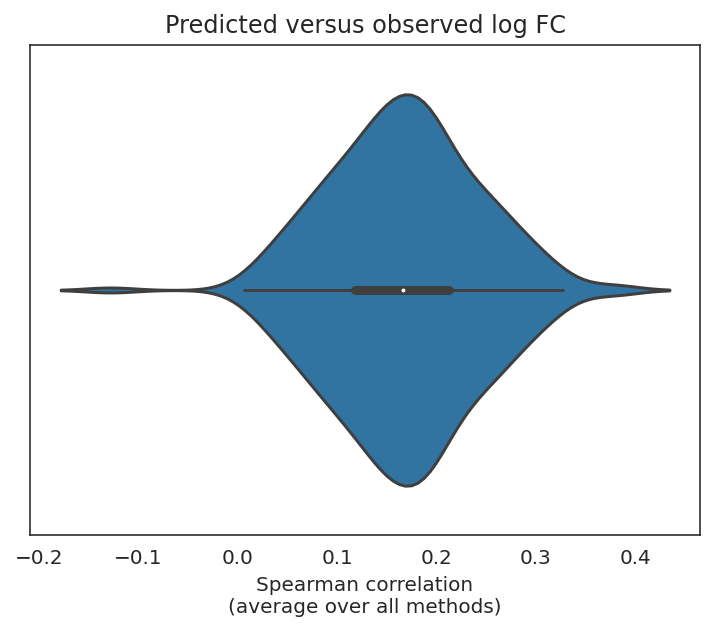

In [123]:
spearman_mean_across_methods = evaluationResults.groupby("perturbation")["spearman"].mean()
spearman_mean_across_methods = pd.DataFrame(spearman_mean_across_methods)
spearman_mean_across_methods.set_axis(['spearman_mean_across_methods'], axis=1, inplace=True)
evaluationResults = evaluationResults.merge(spearman_mean_across_methods, 
                                            how = "left", left_on="perturbation", right_index=True)
evaluationResults["spearman_improvement"] = evaluationResults["spearman"] - evaluationResults["spearman_mean_across_methods"]

# evaluationResults.index = evaluationResults.index.droplevel(0)
plotMeanSpearman = sns.violinplot( spearman_mean_across_methods.iloc[:,0])
plotMeanSpearman.set(title = "Predicted versus observed log FC", xlabel="Spearman correlation\n(average over all methods)")

In [175]:
noPredictionMade = evaluationResults.iloc[[x==0 for x in evaluationResults["spearman"]],:]['perturbation']
noPredictionMade = set(noPredictionMade)
noPredictionMade
evaluationResults["somePredictionRefused"] = evaluationResults["perturbation"].isin(noPredictionMade) 
evaluationResults.to_csv("networksExperimentEvaluation.csv")
evaluationResults.head()

,spearman,spearmanp,perturbation,index,network,p,threshold_number,pruning,spearman_mean_across_methods,spearman_improvement,noPredictionMade,somePredictionRefused
0,0.239083,3.709844e-35,ALX3,0,encodeDNase,0.001,2000,harsh,0.239078,0.000004,False,False
1,0.189472,1.834027e-22,ALX4,0,encodeDNase,0.001,2000,harsh,0.189473,-0.000001,False,False
2,0.202574,1.650616e-25,AR,0,encodeDNase,0.001,2000,harsh,0.202589,-0.000015,False,False
3,0.189612,1.706266e-22,ARNT2,0,encodeDNase,0.001,2000,harsh,0.189637,-0.000026,False,False
4,0.246724,2.126742e-37,ASCL1,0,encodeDNase,0.001,2000,harsh,0.246726,-0.000002,False,False


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


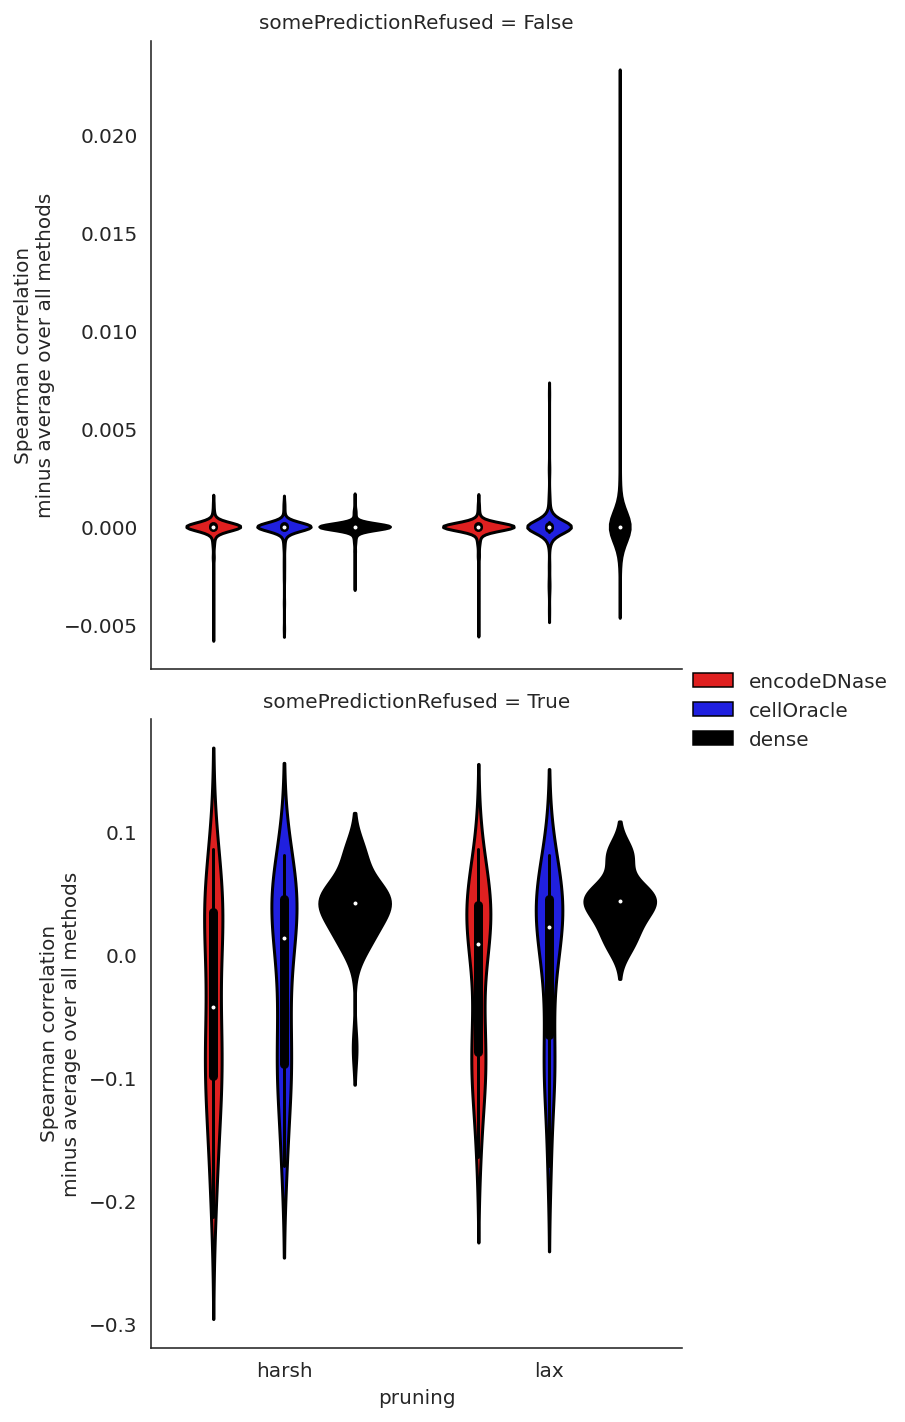

In [174]:
baseNetworkComparisonFigure = sns.FacetGrid(evaluationResults, 
                                            row ='somePredictionRefused', 
                                            sharey = False, 
                                            height=5, 
                                            aspect=1)
baseNetworkComparisonFigure.map(sns.violinplot, "pruning", "spearman_improvement", "network", 
                                palette=["r", "b", "k"]).add_legend()
baseNetworkComparisonFigure.set(ylabel="Spearman correlation\nminus average over all methods")
plt.show()